In [1]:
import os
from pathlib import Path

from itertools import chain

import datetime

import math
import numpy as np
import pandas as pd

from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

# https://github.com/reichlab/timeseriesutils
from timeseriesutils import featurize

In [3]:
# config settings

# date of forecast generation
#forecast_date = datetime.date.today() 
forecast_date = datetime.date(2022, 5, 16) # set mid May - July as experimental forecast date phase 

# most recent Saturday: weekly forecasts look forward from this date
last_sat = forecast_date - datetime.timedelta((forecast_date.weekday() + 2) % 7)
last_sat

# maximum forecast horizon
max_horizon = 28

# number of bags
num_bags = 100
bag_frac_samples = 0.7

# quantile levels at which to generate predictions
q_levels = [0.01, 0.025, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35,
            0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80,
            0.85, 0.90, 0.95, 0.975, 0.99]
q_labels = ['0.010', '0.025', '0.050', '0.100', '0.150', '0.200', '0.250', '0.300', '0.350',
            '0.400', '0.450', '0.500', '0.550', '0.600', '0.650', '0.700', '0.750', '0.800',
            '0.850', '0.900', '0.950', '0.975', '0.990']

In [4]:
def load_data(pathogen):
    path = max(Path('data').glob(f'{pathogen}_data_cached_*.csv'))
    df = pd.read_csv(path)
    df = df.loc[df['date'] >= '2021-03-01']
    df['date'] = pd.to_datetime(df['date'])
    
    # log population -- a feature, but used in plots immediately below
    df['log_pop'] = np.log(df['population'])
    
    # process response variable:
    # - replace low values with 0.1, selected by looking at plots
    # - fourth root transform to stabilize variability
    # - divide by location-specific 95th percentile
    # - center relative to location-specific mean
    #   (note non-standard order of center/scale)
    df['hosp_rate_4rt'] = df['hosp_rate']
    df.loc[df['hosp_rate_4rt'] < 0.1, 'hosp_rate_4rt'] = 0.1
    df['hosp_rate_4rt'] = df['hosp_rate_4rt'] ** 0.25
    df['hosp_rate_4rt_scale_factor'] = df \
        .groupby('location')['hosp_rate_4rt'] \
        .transform(lambda x: x.quantile(0.95))
    
    df['hosp_rate_4rt_cs'] = df['hosp_rate_4rt'] / (df['hosp_rate_4rt_scale_factor'] + 0.01)
    df['hosp_rate_4rt_center_factor'] = df \
        .groupby('location')['hosp_rate_4rt_cs'] \
        .transform(lambda x: x.mean())
    df['hosp_rate_4rt_cs'] = df['hosp_rate_4rt_cs'] - df['hosp_rate_4rt_center_factor']
    
    return(df) 

      location       date  hosps  location_name  population   pop100k  \
340         25 2021-03-01  101.0  Massachusetts     6892503  68.92503   
341         25 2021-03-02  102.0  Massachusetts     6892503  68.92503   
342         25 2021-03-03  114.0  Massachusetts     6892503  68.92503   
343         25 2021-03-04  113.0  Massachusetts     6892503  68.92503   
344         25 2021-03-05  102.0  Massachusetts     6892503  68.92503   
...        ...        ...    ...            ...         ...       ...   
1047        25 2023-02-06  120.0  Massachusetts     6892503  68.92503   
1048        25 2023-02-07  126.0  Massachusetts     6892503  68.92503   
1049        25 2023-02-08  108.0  Massachusetts     6892503  68.92503   
1050        25 2023-02-09  112.0  Massachusetts     6892503  68.92503   
1051        25 2023-02-10  112.0  Massachusetts     6892503  68.92503   

      hosp_rate    log_pop  hosp_rate_4rt  hosp_rate_4rt_scale_factor  \
340    1.465360  15.745945       1.100237         

<Axes: xlabel='date', ylabel='hosp_rate_4rt_cs'>

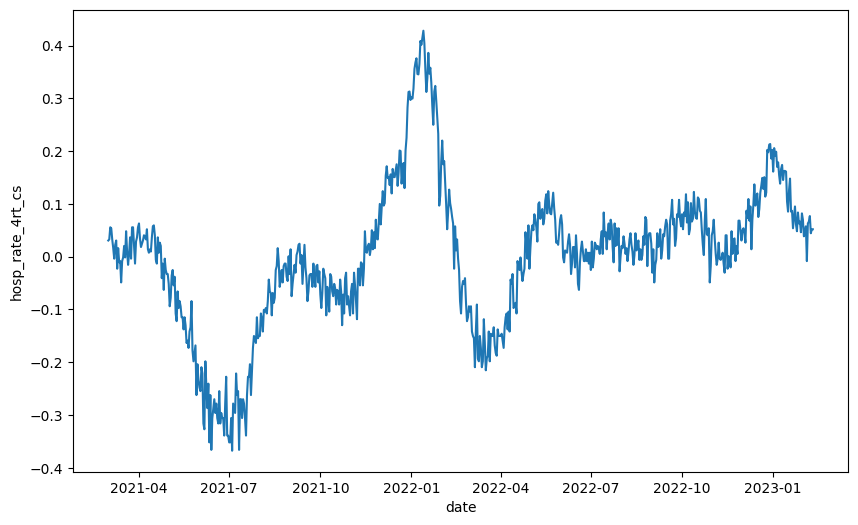

In [5]:
covid_df = load_data(pathogen='covid')
print(covid_df)

fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
sns.lineplot(data=covid_df, x='date', y='hosp_rate_4rt_cs', ax=ax)

# Calculate features

### Misc. features based on date and location variables

In [6]:
feat_names = []

# one-hot encodings of day of week and location
covid_df['dow'] = pd.to_datetime(covid_df.date).dt.dayofweek

for c in ['dow']:
    ohe = pd.get_dummies(covid_df[c], prefix=c)
    covid_df = pd.concat([covid_df, ohe], axis=1)
    feat_names = feat_names + list(ohe.columns)

feat_names 

['dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6']

In [10]:
covid_df, new_feat_names = featurize.featurize_data(
    covid_df,
    features = [
        {
            'fun': 'windowed_taylor_coefs',
            'args': {
                'columns': 'hosp_rate_4rt_cs',
                'taylor_degree': 2,
                'window_align': 'trailing',
                'window_size': [28, 42],
                'fill_edges': False
            }
        },
        {
            'fun': 'windowed_taylor_coefs',
            'args': {
                'columns': 'hosp_rate_4rt_cs',
                'taylor_degree': 1,
                'window_align': 'trailing',
                'window_size': [14],
                'fill_edges': False
            }
        },
        {
            'fun': 'rollmean',
            'args': {
                'columns': 'hosp_rate_4rt_cs',
                'window_size': [7, 14]
            }
        }
    ])
feat_names = feat_names + new_feat_names

covid_df, new_feat_names = featurize.featurize_data(
    covid_df,
    features = [
        {
            'fun': 'lag',
            'args': {
                'columns': new_feat_names,
                'lags': [7, 14]
            }
        }
    ])
feat_names = feat_names + new_feat_names

covid_df['empirical_deriv'] = (covid_df['hosp_rate_4rt_cs_rollmean_w7'] - covid_df['hosp_rate_4rt_cs_rollmean_w7_lag7']) / 7
feat_names =feat_names + ['empirical_deriv']

print(covid_df)
print(feat_names)

** On entry to DGELSD, parameter number  6 had an illegal value


LinAlgError: SVD did not converge in Linear Least Squares

In [31]:
# drop features that involve absolute level
# feat_names = ['log_pop', 'pathogen_covid', 'location_01', 'location_02', 'location_04',
feat_names = ['log_pop', 'location_01', 'location_02', 'location_04',
    'location_05', 'location_06', 'location_08', 'location_09', 'location_10', 'location_11',
    'location_12', 'location_13', 'location_15', 'location_16', 'location_17', 'location_18',
    'location_19', 'location_20', 'location_21', 'location_22', 'location_23', 'location_24',
    'location_25', 'location_26', 'location_27', 'location_28', 'location_29', 'location_30',
    'location_31', 'location_32', 'location_33', 'location_34', 'location_35', 'location_36',
    'location_37', 'location_38', 'location_39', 'location_40', 'location_41', 'location_42',
    'location_44', 'location_45', 'location_46', 'location_47', 'location_48', 'location_49',
    'location_50', 'location_51', 'location_53', 'location_54', 'location_55', 'location_56',
    'location_60', 'location_72', 'location_78', 'location_US', 'dow_0', 'dow_1', 'dow_2',
    'dow_3', 'dow_4', 'dow_5', 'dow_6', 'hosp_rate_4rt_cs_taylor_d1_w28t_sNone',
    'hosp_rate_4rt_cs_taylor_d2_w28t_sNone', 'hosp_rate_4rt_cs_taylor_d1_w42t_sNone',
    'hosp_rate_4rt_cs_taylor_d2_w42t_sNone', 'hosp_rate_4rt_cs_taylor_d1_w14t_sNone',
    'hosp_rate_4rt_cs_taylor_d1_w28t_sNone_lag7', 'hosp_rate_4rt_cs_taylor_d1_w28t_sNone_lag14',
    'hosp_rate_4rt_cs_taylor_d2_w28t_sNone_lag7', 'hosp_rate_4rt_cs_taylor_d2_w28t_sNone_lag14',
    'hosp_rate_4rt_cs_taylor_d1_w42t_sNone_lag7', 'hosp_rate_4rt_cs_taylor_d1_w42t_sNone_lag14',
    'hosp_rate_4rt_cs_taylor_d2_w42t_sNone_lag7', 'hosp_rate_4rt_cs_taylor_d2_w42t_sNone_lag14',
    'hosp_rate_4rt_cs_taylor_d1_w14t_sNone_lag7', 'hosp_rate_4rt_cs_taylor_d1_w14t_sNone_lag14',
    'empirical_deriv']

In [32]:
# import importlib
# featurize = importlib.reload(featurize)

# figure out horizons
# last date with observed data
last_obs_date = pd.to_datetime(df.groupby(['location', 'pathogen_covid'])['date'].max().min())
print(f'last_obs_date: {last_obs_date}')

# how far out to forecast to get to 28 days after due date
due_date = forecast_date
extra_horizons_rel_obs = (due_date - last_obs_date.date()).days
effective_horizon_rel_obs = max_horizon + extra_horizons_rel_obs

# add forecast targets
df_with_pred_targets, new_feat_names = featurize.featurize_data(
    df, group_columns=['location', 'pathogen_covid'],
    features = [
        {
            'fun': 'horizon_targets',
            'args': {
                'columns': 'hosp_rate_4rt_cs',
                'horizons': [(i+1) for i in range(effective_horizon_rel_obs)]
            }
        }
    ])
feat_names = feat_names + new_feat_names

# we will model the differences between the prediction target and the most
# recent observed value
df_with_pred_targets['delta_target'] = df_with_pred_targets['hosp_rate_4rt_cs_target'] - df_with_pred_targets['hosp_rate_4rt_cs_taylor_d0_w42t_sNone']

print(new_feat_names)
print(df_with_pred_targets)

last_obs_date: 2022-12-09 00:00:00
['horizon']
      location       date   hosps  location_name  population     pop100k  \
0           01 2020-12-01   285.0        Alabama     4903185    49.03185   
1           01 2020-12-02   294.0        Alabama     4903185    49.03185   
2           01 2020-12-03   279.0        Alabama     4903185    49.03185   
3           01 2020-12-04   294.0        Alabama     4903185    49.03185   
4           01 2020-12-05   272.0        Alabama     4903185    49.03185   
...        ...        ...     ...            ...         ...         ...   
55427       US 2022-12-07  5384.0  United States   332875137  3328.75137   
55428       US 2022-12-08  3279.0  United States   332875137  3328.75137   
55429       US 2022-12-08  5208.0  United States   332875137  3328.75137   
55430       US 2022-12-09  3209.0  United States   332875137  3328.75137   
55431       US 2022-12-09  5218.0  United States   332875137  3328.75137   

       hosp_rate    log_pop  hosp_rate_4

In [ ]:
list(df_with_pred_targets.columns)

In [33]:
df_with_pred_targets['horizon']

0         1
1         1
2         1
3         1
4         1
         ..
55427    31
55428    31
55429    31
55430    31
55431    31
Name: horizon, Length: 1718392, dtype: int64

In [34]:
# drop rows with missing feature values
# these show up for early dates and American Samoa
drop_rows = (np.sum(np.isnan(df_with_pred_targets.loc[:, feat_names]), axis=1) > 0).values
print(df_with_pred_targets.loc[drop_rows].date.unique())
print(df_with_pred_targets.loc[drop_rows & (df_with_pred_targets.date >= '2021-08-23')].location_name.unique())

df_with_pred_targets = df_with_pred_targets.loc[~drop_rows]

['2020-12-01T00:00:00.000000000' '2020-12-02T00:00:00.000000000'
 '2020-12-03T00:00:00.000000000' '2020-12-04T00:00:00.000000000'
 '2020-12-05T00:00:00.000000000' '2020-12-06T00:00:00.000000000'
 '2020-12-07T00:00:00.000000000' '2020-12-08T00:00:00.000000000'
 '2020-12-09T00:00:00.000000000' '2020-12-10T00:00:00.000000000'
 '2020-12-11T00:00:00.000000000' '2020-12-12T00:00:00.000000000'
 '2020-12-13T00:00:00.000000000' '2020-12-14T00:00:00.000000000'
 '2020-12-15T00:00:00.000000000' '2020-12-16T00:00:00.000000000'
 '2020-12-17T00:00:00.000000000' '2020-12-18T00:00:00.000000000'
 '2020-12-19T00:00:00.000000000' '2020-12-20T00:00:00.000000000'
 '2020-12-21T00:00:00.000000000' '2020-12-22T00:00:00.000000000'
 '2020-12-23T00:00:00.000000000' '2020-12-24T00:00:00.000000000'
 '2020-12-25T00:00:00.000000000' '2020-12-26T00:00:00.000000000'
 '2020-12-27T00:00:00.000000000' '2020-12-28T00:00:00.000000000'
 '2020-12-29T00:00:00.000000000' '2020-12-30T00:00:00.000000000'
 '2020-12-31T00:00:00.000

In [35]:
# Drop rows based on data for influenza between June 1 and Oct 1, 2022
# off-season data was unreliable
drop_rows = (df_with_pred_targets['date'] >= '2022-06-01') & \
    (df_with_pred_targets['date'] < '2022-10-01') & \
    (df_with_pred_targets['pathogen_covid'] == 0)

print(df_with_pred_targets.loc[drop_rows].date.unique())
print(df_with_pred_targets.loc[drop_rows].pathogen_covid.unique())

df_with_pred_targets = df_with_pred_targets.loc[~drop_rows]

['2022-06-01T00:00:00.000000000' '2022-06-02T00:00:00.000000000'
 '2022-06-03T00:00:00.000000000' '2022-06-04T00:00:00.000000000'
 '2022-06-05T00:00:00.000000000' '2022-06-06T00:00:00.000000000'
 '2022-06-07T00:00:00.000000000' '2022-06-08T00:00:00.000000000'
 '2022-06-09T00:00:00.000000000' '2022-06-10T00:00:00.000000000'
 '2022-06-11T00:00:00.000000000' '2022-06-12T00:00:00.000000000'
 '2022-06-13T00:00:00.000000000' '2022-06-14T00:00:00.000000000'
 '2022-06-15T00:00:00.000000000' '2022-06-16T00:00:00.000000000'
 '2022-06-17T00:00:00.000000000' '2022-06-18T00:00:00.000000000'
 '2022-06-19T00:00:00.000000000' '2022-06-20T00:00:00.000000000'
 '2022-06-21T00:00:00.000000000' '2022-06-22T00:00:00.000000000'
 '2022-06-23T00:00:00.000000000' '2022-06-24T00:00:00.000000000'
 '2022-06-25T00:00:00.000000000' '2022-06-26T00:00:00.000000000'
 '2022-06-27T00:00:00.000000000' '2022-06-28T00:00:00.000000000'
 '2022-06-29T00:00:00.000000000' '2022-06-30T00:00:00.000000000'
 '2022-07-01T00:00:00.000

In [36]:
# "test set" df used to generate look-ahead predictions
df_test = df_with_pred_targets \
    .loc[df_with_pred_targets.date == df_with_pred_targets.date.max()] \
    .copy()
x_test = df_test[feat_names]

# "train set" df for model fitting; target value non-missing
df_train = df_with_pred_targets.loc[~df_with_pred_targets['delta_target'].isna().values]
x_train = df_train[feat_names]
y_train = df_train['delta_target']

In [37]:
# Set up partitions of data into time blocks for bagging
# TODO? Consider also partitioning by pathogen
T = (pd.to_datetime(df_train.date.max()) - pd.to_datetime(df_train.date.min())).days
num_time_blocks = T // 28
time_block_starts = [pd.to_datetime(df_train.date.min()) + datetime.timedelta(days=28*i) \
    for i in range(num_time_blocks)]
time_block_lengths = [28]*(num_time_blocks - 1) + \
    [(pd.to_datetime(df_train.date.max()) - time_block_starts[-1] + datetime.timedelta(days=1)).days]
time_block_dates = [[(time_block_starts[j] + datetime.timedelta(days=i)) \
    for i in range(time_block_lengths[j])] for j in range(num_time_blocks)]

In [38]:
# training loop over bags
# for q_level, q_label in zip(q_levels, q_labels):
    # print(q_label)

oob_preds_by_bag = np.empty((x_train.shape[0], num_bags))
oob_preds_by_bag[:] = np.nan
test_preds_by_bag = np.empty((x_test.shape[0], num_bags))

for b in range(num_bags):
    print(f'bag number {b+1}')
    # get indices of observations that are in bag
    bag_block_inds = np.random.choice(num_time_blocks,
                            size = int(num_time_blocks*bag_frac_samples),
                            replace=False).astype(int)
    bag_block_inds = np.sort(bag_block_inds)
    bag_obs_dates = [time_block_dates[j] for j in bag_block_inds]
    bag_obs_dates = [str(d.date()) for d in list(chain.from_iterable(bag_obs_dates))]
    bag_obs_inds = df_train['date'].isin(bag_obs_dates)

    # oob_block_inds = [i for i in range(num_time_blocks) if i not in bag_block_inds]
    # oob_obs_dates = [time_block_dates[j] for j in oob_block_inds]
    # oob_obs_dates = [str(d.date()) for d in list(chain.from_iterable(oob_obs_dates))]
    # oob_obs_inds = df_train['date'].isin(oob_obs_dates)
    
    # fit to bag
    model = lgb.LGBMRegressor(verbosity=-1,
                                hist_pool_size=1000,
                                objective='mean_absolute_error')
                            #   objective='quantile',
                            #   alpha = q_level)
    model.fit(X=x_train.loc[bag_obs_inds, :], y=y_train.loc[bag_obs_inds])
    
    # oob predictions and test set predictions
    oob_preds_by_bag[~bag_obs_inds, b] = model.predict(X=x_train.loc[~bag_obs_inds, :])
    test_preds_by_bag[:, b] = model.predict(X=x_test)


bag number 1
bag number 2
bag number 3
bag number 4
bag number 5
bag number 6
bag number 7
bag number 8
bag number 9
bag number 10
bag number 11
bag number 12
bag number 13
bag number 14
bag number 15
bag number 16
bag number 17
bag number 18
bag number 19
bag number 20
bag number 21
bag number 22
bag number 23
bag number 24
bag number 25
bag number 26
bag number 27
bag number 28
bag number 29
bag number 30
bag number 31
bag number 32
bag number 33
bag number 34
bag number 35
bag number 36
bag number 37
bag number 38
bag number 39
bag number 40
bag number 41
bag number 42
bag number 43
bag number 44
bag number 45
bag number 46
bag number 47
bag number 48
bag number 49
bag number 50
bag number 51
bag number 52
bag number 53
bag number 54
bag number 55
bag number 56
bag number 57
bag number 58
bag number 59
bag number 60
bag number 61
bag number 62
bag number 63
bag number 64
bag number 65
bag number 66
bag number 67
bag number 68
bag number 69
bag number 70
bag number 71
bag number 72
b

In [39]:
df_train['oob_pred'] = np.nanmedian(oob_preds_by_bag, axis=1)
df_test['delta_hat_stage1'] = np.median(test_preds_by_bag, axis=1)

/var/folders/xs/t5qwsz_d0hlc6vkx6wzr98f5q78pzl/T/ipykernel_34071/1539517525.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['oob_pred'] = np.nanmedian(oob_preds_by_bag, axis=1)


In [ ]:
# qs = df_train.groupby(['log_pop', 'horizon', 'pathogen_covid'])['oob_pred_resid'].quantile(np.arange(0.1, 1.0, 0.1)).reset_index()
# qs
# g = sns.FacetGrid(qs, row='horizon', col='level_3')
# g.map(sns.scatterplot, 'log_pop', 'oob_pred_resid', 'pathogen_covid')

In [40]:
# daily predictions
df_train['oob_pred_resid'] = df_train['oob_pred'] - df_train['delta_target']

for q_level, q_label in zip(q_levels, q_labels):
    # basically do a split conformal idea per location and horizon to get quantiles,
    # but ignore the finite sample size adjustment
    oob_resid_q = df_train.groupby(['location', 'horizon', 'pathogen_covid'])['oob_pred_resid'].quantile(q_level)
    df_test = df_test.merge(oob_resid_q.reset_index(), on=['location', 'horizon', 'pathogen_covid'])
    df_test[q_label] = df_test['delta_hat_stage1'] + df_test['oob_pred_resid']
    df_test.drop(columns=['oob_pred_resid'], inplace=True)

/var/folders/xs/t5qwsz_d0hlc6vkx6wzr98f5q78pzl/T/ipykernel_34071/1976052202.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['oob_pred_resid'] = df_train['oob_pred'] - df_train['delta_target']


In [41]:
# delta_names = [f'delta_hat_q{q_label}' for q_label in q_labels]
cols_to_keep = ['location', 'date', 'pop100k', 'pathogen_covid',
                'hosp_rate_4rt_cs_taylor_d0_w42t_sNone', 'horizon',
                'hosp_rate_4rt_center_factor', 'hosp_rate_4rt_scale_factor']
preds_df = df_test[cols_to_keep + q_labels]
preds_df = pd.melt(preds_df,
                   id_vars=cols_to_keep,
                   var_name='quantile',
                   value_name = 'delta_hat')

# build data frame with predictions on the original scale
preds_df['hosp_rate_4rt_cs_target_hat'] = preds_df['hosp_rate_4rt_cs_taylor_d0_w42t_sNone'] + preds_df['delta_hat']
preds_df['hosp_rate_4rt_target_hat'] = (preds_df['hosp_rate_4rt_cs_target_hat'] + preds_df['hosp_rate_4rt_center_factor']) * preds_df['hosp_rate_4rt_scale_factor']
preds_df['hosp_rate_target_hat'] = preds_df['hosp_rate_4rt_target_hat'] ** 4
preds_df['value'] = preds_df['hosp_rate_target_hat'] * preds_df['pop100k']
preds_df['target_end_date'] = pd.to_datetime(preds_df['date']) + pd.to_timedelta(preds_df['horizon'], unit='days')
preds_df = preds_df[['location', 'target_end_date', 'pathogen_covid', 'quantile', 'value']]

# daily predictions: add target column with horizon relative to forecast date
preds_df['forecast_date'] = str(forecast_date)
preds_df['horizon'] = (preds_df['target_end_date'].dt.date - forecast_date).dt.days

daily_preds_df = preds_df.loc[(preds_df['horizon'] > 0) & (preds_df['horizon'] <= max_horizon)]
daily_preds_df['target'] = daily_preds_df['horizon'].astype('str') + ' day ahead inc hosp'
daily_preds_df['type'] = 'quantile'
daily_preds_df.drop(columns=['horizon'], inplace=True)

# add point predictions
daily_pt_preds = daily_preds_df.loc[daily_preds_df['quantile'] == '0.500'].copy()
daily_pt_preds['type'] = 'point'
daily_pt_preds['quantile'] = 'NA'
daily_preds_df = pd.concat([daily_preds_df, daily_pt_preds], axis=0)
daily_preds_df

/var/folders/xs/t5qwsz_d0hlc6vkx6wzr98f5q78pzl/T/ipykernel_34071/747334403.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_preds_df['target'] = daily_preds_df['horizon'].astype('str') + ' day ahead inc hosp'
/var/folders/xs/t5qwsz_d0hlc6vkx6wzr98f5q78pzl/T/ipykernel_34071/747334403.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_preds_df['type'] = 'quantile'
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy 

location target_end_date  pathogen_covid quantile        value  \
324         01      2022-12-13               0    0.010     8.894132   
325         01      2022-12-13               1    0.010    37.526331   
326         02      2022-12-13               0    0.010     3.408339   
327         02      2022-12-13               1    0.010     3.144491   
328         04      2022-12-13               0    0.010    75.814940   
...        ...             ...             ...      ...          ...   
40171       72      2023-01-09               0       NA    19.400218   
40172       72      2023-01-09               1       NA    41.045202   
40173       78      2023-01-09               1       NA     0.164014   
40174       US      2023-01-09               0       NA  2697.315030   
40175       US      2023-01-09               1       NA  5959.950223   

      forecast_date                 target      type  
324      2022-12-12   1 day ahead inc hosp  quantile  
325      2022-12-12   1 day ahead inc hosp  quantile  
326      2022-12-12   1 day ahead inc hosp  quantile  
327      2022-12-12   1 day ahead inc hosp  quantile  
328      2022-12-12   1 day ahead inc hosp  quantile  
...             ...                    ...       ...  
40171    2022-12-12  28 day ahead inc hosp     point  
40172    2022-12-12  28 day ahead inc hosp     point  
40173    2022-12-12  28 day ahead inc hosp     point  
40174    2022-12-12  28 day ahead inc hosp     point  
40175    2022-12-12  28 day ahead inc hosp     point  

[72576 rows x 8 columns]

In [42]:
# weekly scale for influenza
# just aggregate the quantiles
# this is wrong, but in a conservative way -- assumes exact dependence
# across daily forecast horizons, which yields wider intervals
weekly_flu_preds_df = preds_df \
    .loc[(preds_df['pathogen_covid'] == 0) &
         (preds_df['target_end_date'].dt.date > last_sat) &
         (preds_df['target_end_date'].dt.date <= (last_sat + datetime.timedelta(days=28)))] \
    .copy() \
    .assign(horizon = lambda x: x['horizon'] // 7 + 1) \
    .groupby(['location', 'quantile', 'horizon', 'forecast_date']) \
    .sum() \
    .reset_index() \
    .assign(
        target_end_date = lambda x: pd.to_datetime(last_sat) + pd.to_timedelta(x['horizon'] * 7, unit='days'),
        target = lambda x: x['horizon'].astype('str') + ' wk ahead inc flu hosp',
        type = 'quantile'
    ) \
    .drop(columns=['pathogen_covid', 'horizon'])

# add point predictions
weekly_pt_preds = weekly_flu_preds_df.loc[weekly_flu_preds_df['quantile'] == '0.500'].copy()
weekly_pt_preds['type'] = 'point'
weekly_pt_preds['quantile'] = 'NA'
weekly_flu_preds_df = pd.concat([weekly_flu_preds_df, weekly_pt_preds], axis=0)

weekly_flu_preds_df

location quantile forecast_date         value target_end_date  \
0          01    0.010    2022-12-12      7.903128      2022-12-10   
1          01    0.010    2022-12-12     57.035437      2022-12-17   
2          01    0.010    2022-12-12     32.339664      2022-12-24   
3          01    0.010    2022-12-12      9.928645      2022-12-31   
4          01    0.010    2022-12-12      3.363338      2023-01-07   
...       ...      ...           ...           ...             ...   
6035       US       NA    2022-12-12   2889.696323      2022-12-10   
6036       US       NA    2022-12-12  23179.203699      2022-12-17   
6037       US       NA    2022-12-12  22873.404519      2022-12-24   
6038       US       NA    2022-12-12  20617.727962      2022-12-31   
6039       US       NA    2022-12-12  16956.909095      2023-01-07   

                       target      type  
0     0 wk ahead inc flu hosp  quantile  
1     1 wk ahead inc flu hosp  quantile  
2     2 wk ahead inc flu hosp  quantile  
3     3 wk ahead inc flu hosp  quantile  
4     4 wk ahead inc flu hosp  quantile  
...                       ...       ...  
6035  0 wk ahead inc flu hosp     point  
6036  1 wk ahead inc flu hosp     point  
6037  2 wk ahead inc flu hosp     point  
6038  3 wk ahead inc flu hosp     point  
6039  4 wk ahead inc flu hosp     point  

[6360 rows x 7 columns]

In [43]:
daily_preds_df.loc[preds_df['pathogen_covid'] == 0] \
    .drop(columns='pathogen_covid') \
    .to_csv(f'submissions/flu/UMass-gbq/{str(forecast_date)}-UMass-gbq-daily.csv', index=False)

weekly_flu_preds_df.to_csv(f'submissions/flu/UMass-gbq/{str(forecast_date)}-UMass-gbq.csv', index=False)

daily_preds_df.loc[preds_df['pathogen_covid'] == 1] \
    .drop(columns='pathogen_covid') \
    .to_csv(f'submissions/covid/UMass-gbq/{str(forecast_date)}-UMass-gbq.csv', index=False)

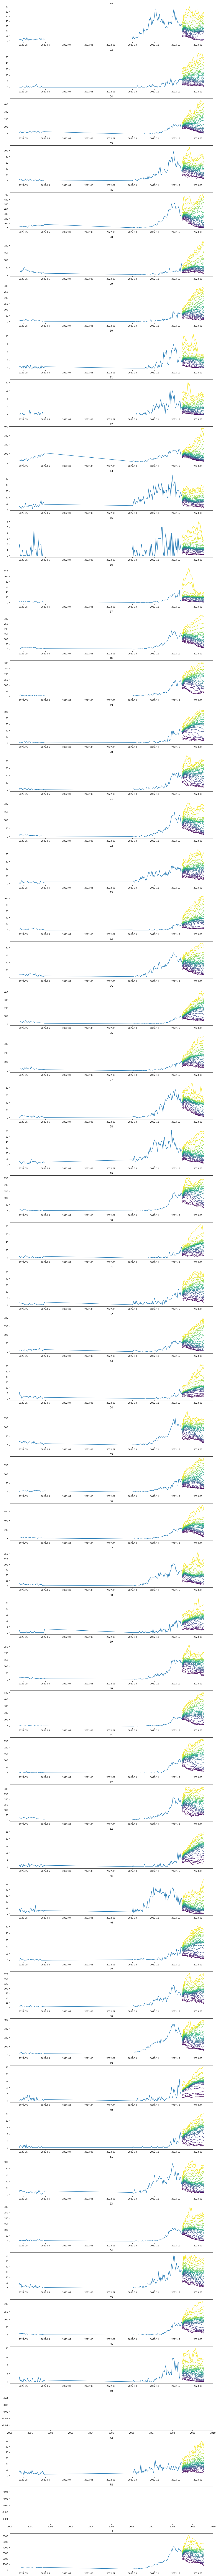

In [44]:
cmap = cm.get_cmap('viridis')
fig_ncol = 1
fig_nrow = math.ceil(len(df_with_pred_targets.location.unique()) / fig_ncol)
fig, ax = plt.subplots(fig_nrow, fig_ncol, figsize=(14, 3 * fig_nrow), squeeze=False)

for i, loc in enumerate(df_with_pred_targets.location.unique()):
    row_ind = ((i) // fig_ncol)
    col_ind = (i) % fig_ncol
    loc_data = df_with_pred_targets.loc[(df_with_pred_targets.pathogen_covid == 0) & (df_with_pred_targets.location == loc) & (df_with_pred_targets.date >= "2022-01-01")].sort_values('date')
    ax[row_ind, col_ind].plot(pd.to_datetime(loc_data.date), loc_data.hosps)
    for q_level, q_label in zip(q_levels, q_labels):
        loc_q_preds = preds_df.loc[(preds_df.pathogen_covid == 0) & (preds_df.location == loc) & (preds_df['quantile'] == q_label)].sort_values('target_end_date')
        ax[row_ind, col_ind].plot(loc_q_preds.target_end_date, loc_q_preds.value, c=cmap(q_level))
    # ax[row_ind, col_ind].set_xlim(np.min(h_data.date), np.max(h_data.date))
    ax[row_ind, col_ind].set(title=loc)
    # ax[row_ind, col_ind].legend()

plt.tight_layout()
plt.show()

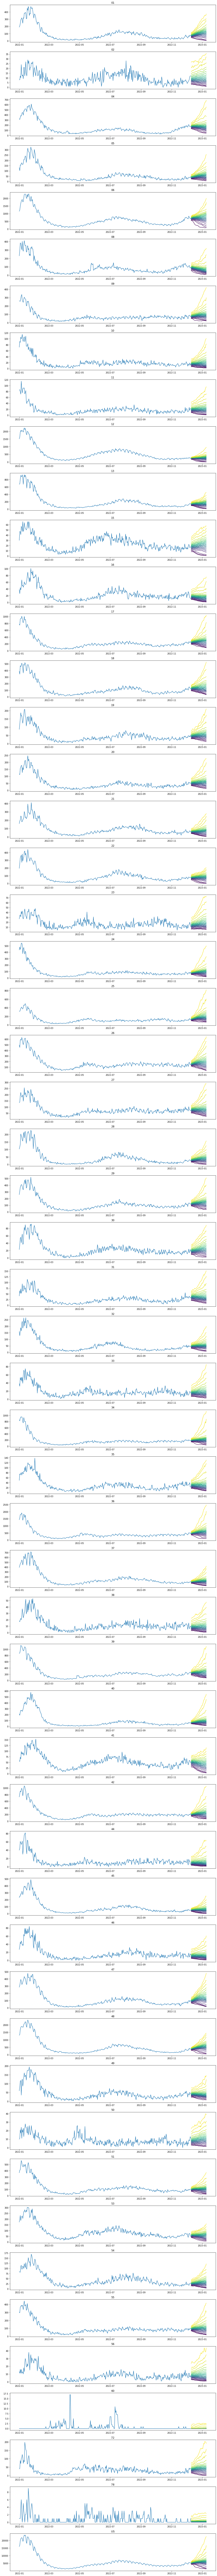

In [45]:
cmap = cm.get_cmap('viridis')
fig_ncol = 1
fig_nrow = math.ceil(len(df_with_pred_targets.location.unique()) / fig_ncol)
fig, ax = plt.subplots(fig_nrow, fig_ncol, figsize=(14, 3 * fig_nrow), squeeze=False)

for i, loc in enumerate(df_with_pred_targets.location.unique()):
    row_ind = ((i) // fig_ncol)
    col_ind = (i) % fig_ncol
    loc_data = df_with_pred_targets.loc[(df_with_pred_targets.pathogen_covid == 1) & (df_with_pred_targets.location == loc) & (df_with_pred_targets.date >= "2022-01-01")].sort_values('date')
    ax[row_ind, col_ind].plot(pd.to_datetime(loc_data.date), loc_data.hosps)
    for q_level, q_label in zip(q_levels, q_labels):
        loc_q_preds = preds_df.loc[(preds_df.pathogen_covid == 1) & (preds_df.location == loc) & (preds_df['quantile'] == q_label)].sort_values('target_end_date')
        ax[row_ind, col_ind].plot(loc_q_preds.target_end_date, loc_q_preds.value, c=cmap(q_level))
    # ax[row_ind, col_ind].set_xlim(np.min(h_data.date), np.max(h_data.date))
    ax[row_ind, col_ind].set(title=loc)
    # ax[row_ind, col_ind].legend()

plt.tight_layout()
plt.show()